In [1]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_predict

from transplant.data.dataset import Dataset
from transplant.data.learningset import Learningset
from transplant.config import *
from transplant.tools.analyse_prediction import *

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
%matplotlib inline

np.random.seed(42)

In [2]:
learningset = Learningset()

train, test = learningset.get_data_merged_dynamic_flatten_full(full_df=True)
X_train=train.drop('target', axis=1)
X_test=test.drop('target', axis=1)
y_train=train['target']
y_test=test['target']

# Concat data
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

/home/gillesa/anaconda3/envs/transplant/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1019: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [3]:
ratio = float(np.sum(y == 0)) / np.sum(y == 1)

model = XGBClassifier(learning_rate=0.01,
                      max_depth=12,
                      missing=np.nan,
                      subsample = 0.85,
                      n_estimators=500,
                      random_state=42,
                      scale_pos_weight=ratio,
                      n_jobs=-1,
                      min_child_weight=1,
                      gamma=0.5,
                      reg_lambda=1,
                      reg_alpha=0,
                      silent=True)

In [4]:
# Cross Validation
all_pred = cross_val_predict(model, X[MODEL_FEATURES], y, cv=5)
all_pred_proba = cross_val_predict(model, X[MODEL_FEATURES], y, cv=5,
                                    method='predict_proba')

print(round(metrics.accuracy_score(y, all_pred), 3))

0.77


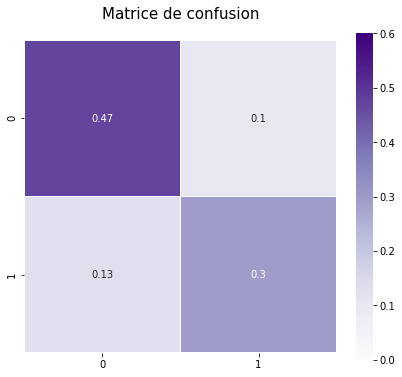

In [5]:
from sklearn.metrics import confusion_matrix

colormap = plt.cm.Purples
plt.figure(figsize=(7,6))
plt.title('Matrice de confusion', y=1.05, size=15)
sns.heatmap(confusion_matrix(y, all_pred)/len(y),linewidths=0.1, 
            square=True, cmap=colormap, linecolor='white', annot=True,
           vmin=0, vmax=0.6)

In [6]:
cm = metrics.confusion_matrix(y, all_pred)
cm

array([[156,  33],
       [ 43,  98]])

In [7]:
result = analyse_prediction(X, y, features_list=MODEL_FEATURES, 
                            model='', pred=all_pred, proba=all_pred_proba)

good, bad = get_good_bad_result(result)
good.reset_index(drop=True, inplace=True)
bad.reset_index(drop=True, inplace=True)

In [8]:
# good predictions
good.head()

,Aspirations_donor,Insuffisance_renale,PAPS,PFO,Poids_donor,Sex_donor,Taille,diabetes,oto_score,pathologie,plasmapherese,preoperative_ECMO,preoperative_ICU,preoperative_mechanical_ventilation,preoperative_pulmonary_hypertension,preoperative_vasopressor,retransplant,sexe,super_urgence,thoracic_surgery_history,time_on_waiting_liste,transplanted_twice_during_study_period,length_op,PASs_mean,PNId_mean,PNIs_mean,SpO2_mean,SvO2 (m)_mean,VT_mean,B.I.S_std,DC_std,PNId_std,PNIs_std,SpO2_std,SvO2 (m)_std,B.I.S_max,BIS SR_max,DC_max,FiO2_max,PAPdia_max,PAPmoy_max,Pmax_max,SpO2_max,SvO2 (m)_max,B.I.S_min,BIS SR_min,DC_min,ETCO2_min,FC_min,FR_min,PAPdia_min,PAPmoy_min,PAPsys_min,PASd_min,PASm_min,PASs_min,PEEPtotal_min,PNId_min,PNIm_min,PNIs_min,Pmax_min,Pmean_min,SpO2_min,SvO2 (m)_min,Temp_min,VT_min,SpO2_by_FiO2_min,PASs_minus_PASd_min,PAPsys_minus_PAPdia_min,count_NaN,PAPsys_minus_PAPdia_pre_auc,PASs_minus_PASd_pre_auc,duration_post,duration_pre,BIS SR_pct_pre_post,SpO2_by_FiO2_pct_pre_post,PAPdia_pct_pre_post,prediction,proba,target,id_patient
0,1,0,94.677165,0.0,74.458,0.555,171,0,4,1,0,1,1.0,0.0,0.40824,1.0,0,0,1,0,1,0,476,103.088050,0.000000,0.000000,96.836478,11.014675,196.633124,NaN,1.809629,0.000000,0.000000,16.927719,30.207559,NaN,NaN,6.5,99.0,29.0,35.0,52.0,100.0,97.0,NaN,NaN,0.0,0.0,81.0,0.0,-317.36,-312.36,0.00,0.0,-314.36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,8,-29.923077,-57.670330,63,91,NaN,-0.795665,15.168074,1,0.755218,1,404
1,1,0,60.000000,0.0,59.000,0.000,158,0,1,1,0,0,1.0,0.0,1.00000,0.0,0,0,1,0,1,0,554,96.405405,NaN,NaN,96.821622,NaN,238.371171,NaN,NaN,NaN,NaN,8.782799,NaN,NaN,NaN,NaN,100.0,272.0,276.0,72.0,100.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.00,28,-24.412088,-60.697802,76,91,NaN,-0.294301,-57.045259,1,0.841066,1,66
2,3,0,94.677165,0.0,56.000,1.000,157,0,5,5,0,0,0.0,0.0,0.00000,0.0,0,0,0,0,7,0,474,87.374737,1.216842,2.162105,91.065263,NaN,265.187368,NaN,NaN,8.774204,15.577076,23.926861,NaN,NaN,NaN,NaN,102.0,146.0,150.0,62.0,100.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.00,16,-43.538462,-81.280220,31,91,NaN,-2.114469,-140.173713,0,0.116998,0,82
3,3,0,44.000000,1.0,75.000,1.000,183,0,4,2,0,0,0.0,0.0,1.00000,0.0,0,1,0,1,13,0,510,89.240705,5.397260,8.771037,96.540117,48.641879,307.387476,0.000000,NaN,17.909337,29.145636,5.927964,28.999881,0.0,0.0,NaN,101.0,51.0,65.0,41.0,100.0,79.0,0.0,0.0,NaN,0.0,0.0,0.0,0.00,0.00,0.00,0.0,-26.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,4,-31.714286,-76.587912,96,91,NaN,-0.732658,37.022569,0,0.230526,0,216
4,1,0,42.000000,0.0,74.458,0.555,156,0,6,2,0,0,0.0,0.0,1.00000,0.0,0,0,0,0,1,0,595,82.585570,2.411074,4.484899,96.701342,38.860738,247.401007,15.738481,NaN,12.475499,23.149676,10.263544,33.999641,73.0,30.0,NaN,100.0,41.0,264.0,69.0,100.0,92.0,0.0,0.0,NaN,0.0,54.0,0.0,0.00,0.00,-317.36,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-317.36,4,-14.000000,-78.467033,105,91,274.927536,0.192959,-34.208901,0,0.090339,0,340


In [9]:
# bad predictions
bad.head()

,Aspirations_donor,Insuffisance_renale,PAPS,PFO,Poids_donor,Sex_donor,Taille,diabetes,oto_score,pathologie,plasmapherese,preoperative_ECMO,preoperative_ICU,preoperative_mechanical_ventilation,preoperative_pulmonary_hypertension,preoperative_vasopressor,retransplant,sexe,super_urgence,thoracic_surgery_history,time_on_waiting_liste,transplanted_twice_during_study_period,length_op,PASs_mean,PNId_mean,PNIs_mean,SpO2_mean,SvO2 (m)_mean,VT_mean,B.I.S_std,DC_std,PNId_std,PNIs_std,SpO2_std,SvO2 (m)_std,B.I.S_max,BIS SR_max,DC_max,FiO2_max,PAPdia_max,PAPmoy_max,Pmax_max,SpO2_max,SvO2 (m)_max,B.I.S_min,BIS SR_min,DC_min,ETCO2_min,FC_min,FR_min,PAPdia_min,PAPmoy_min,PAPsys_min,PASd_min,PASm_min,PASs_min,PEEPtotal_min,PNId_min,PNIm_min,PNIs_min,Pmax_min,Pmean_min,SpO2_min,SvO2 (m)_min,Temp_min,VT_min,SpO2_by_FiO2_min,PASs_minus_PASd_min,PAPsys_minus_PAPdia_min,count_NaN,PAPsys_minus_PAPdia_pre_auc,PASs_minus_PASd_pre_auc,duration_post,duration_pre,BIS SR_pct_pre_post,SpO2_by_FiO2_pct_pre_post,PAPdia_pct_pre_post,prediction,proba,target,id_patient
0,3,0,32.000000,0.0,74.458,0.555,187,0,5,2,0,0,0.0,0.0,0.0,0.0,0,1,0,1,7,0,552,96.517179,4.687161,7.273056,98.437613,63.965642,334.314647,11.168785,2.466570,17.950549,27.796007,7.540619,35.274853,67.0,31.0,7.2,100.0,33.0,39.0,53.0,100.0,94.0,0.0,0.0,0.0,0.0,53.0,0.0,-13.0,0.0,0.0,0.0,-319.36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-12.554945,-58.115385,60,91,-100.000000,-0.934641,-62.952524,1,0.929852,0,329
1,1,0,37.000000,0.0,63.000,0.000,150,1,8,6,0,0,0.0,0.0,1.0,0.0,1,0,0,1,19,1,636,87.285714,3.249608,5.427002,97.686028,53.040816,262.070644,14.637281,1.262503,13.449674,22.237545,10.404926,33.537976,98.0,38.0,5.8,99.0,162.0,169.0,44.0,100.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,-15.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-15.774725,-64.456044,46,91,-46.047431,-0.876922,-96.235958,0,0.487847,1,275
2,0,0,94.677165,0.0,90.000,1.000,153,1,0,1,0,0,0.0,0.0,0.0,0.0,0,0,0,0,100,0,517,91.849421,5.779923,9.150579,96.606178,60.110039,263.225869,14.650422,NaN,18.186768,28.605027,12.203365,32.709578,98.0,0.0,NaN,100.0,67.0,71.0,41.0,100.0,84.0,0.0,0.0,NaN,0.0,0.0,0.0,-9.0,-2.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,-26.648352,-82.021978,103,91,NaN,0.085493,-81.614346,0,0.363440,1,249
3,1,0,94.677165,0.0,80.000,1.000,165,0,4,2,1,0,0.0,0.0,0.0,0.0,0,1,0,0,72,0,620,109.777778,11.152979,18.898551,96.059581,63.061192,233.167472,0.000000,2.755290,27.725084,47.095316,13.907029,31.480425,0.0,0.0,20.0,100.0,45.0,57.0,48.0,100.0,97.0,0.0,0.0,0.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-34.252747,-101.456044,61,91,NaN,0.146745,-61.460492,0,0.489149,1,215
4,1,0,67.000000,0.0,65.000,0.000,160,1,6,7,1,0,0.0,0.0,1.0,0.0,0,0,0,0,65,0,650,99.821813,1.029186,1.910906,96.069124,22.815668,273.287250,0.000000,NaN,7.883799,14.589984,12.263986,34.041356,0.0,0.0,NaN,100.0,45.0,54.0,46.0,100.0,93.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,-15.456044,-55.631868,106,91,NaN,0.439274,-110.002833,1,0.712748,0,178


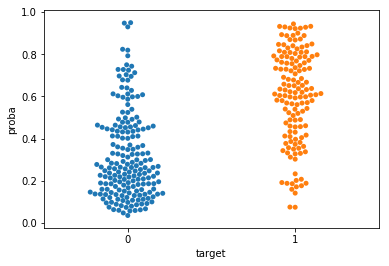

In [10]:
# Répartition des probabilités de l'algo selon la classe (target)
sns.swarmplot(x="target", y="proba", data=result)

/home/gillesa/anaconda3/envs/transplant/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


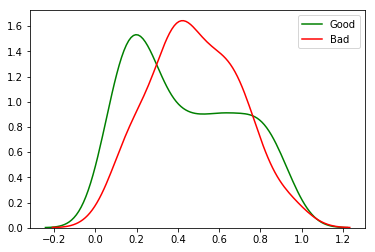

In [11]:
sns.kdeplot(good.proba, label='Good', color='g')
sns.kdeplot(bad.proba, label='Bad', color='r')